<a href="https://colab.research.google.com/github/kunalurkude/Diabetic_Retinopathy_Detectection/blob/main/Bright_Netram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas matplotlib seaborn tensorflow keras opencv-python scikit-learn

**Download the Kaggle Dataset in Google Colab**

In [ ]:
# Install Kaggle API
!pip install kaggle --quiet

# Upload kaggle.json directly
from google.colab import files

print("Please upload your kaggle.json file")
uploaded = files.upload()

# Move kaggle.json to the correct directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the Diabetic Retinopathy dataset
!kaggle datasets download -d tanlikesmath/diabetic-retinopathy-resized

# Extract the dataset
!unzip -q diabetic-retinopathy-resized.zip

print("Dataset downloaded and extracted successfully!")

Please upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/tanlikesmath/diabetic-retinopathy-resized
License(s): unknown
100% 7.24G/7.25G [01:23<00:00, 15.7MB/s]
100% 7.25G/7.25G [01:23<00:00, 93.0MB/s]
Dataset downloaded and extracted successfully!


**Load and Explore the Dataset**

Import Necessary Libraries

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from glob import glob

# Set dataset path
data_dir = "resized_train_cropped"
csv_path = "trainLabels_cropped.csv"

# Load the CSV file
df = pd.read_csv(csv_path)
print("Dataset Loaded Successfully!")

# Display the first few rows
df.head()


Dataset Loaded Successfully!


,Unnamed: 0.1,Unnamed: 0,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1


**Data Preprocessing & Visualization**

1. Check for Missing Values

In [ ]:
# Check for missing values
print("Missing values in dataset:\n", df.isnull().sum())


Missing values in dataset:
 Unnamed: 0.1    0
Unnamed: 0      0
image           0
level           0
dtype: int64


2. Distribution of Diabetic Retinopathy Levels

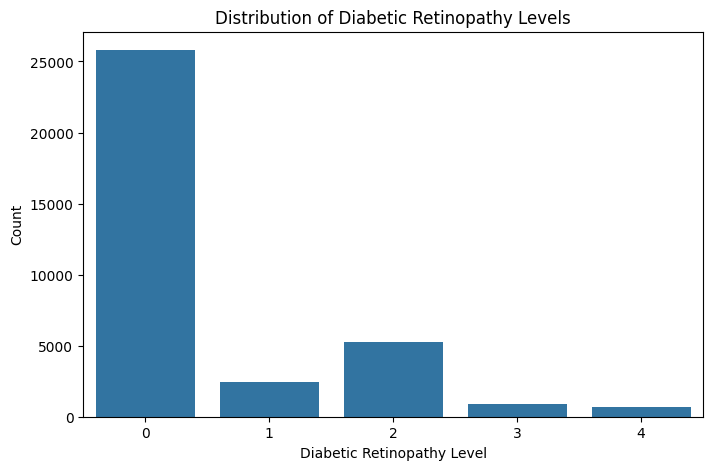

In [ ]:
# Plot the distribution of classes
import seaborn as sns

plt.figure(figsize=(8,5))
sns.countplot(x=df['level'])
plt.title("Distribution of Diabetic Retinopathy Levels")
plt.xlabel("Diabetic Retinopathy Level")
plt.ylabel("Count")
plt.show()


3. Display Some Sample Images

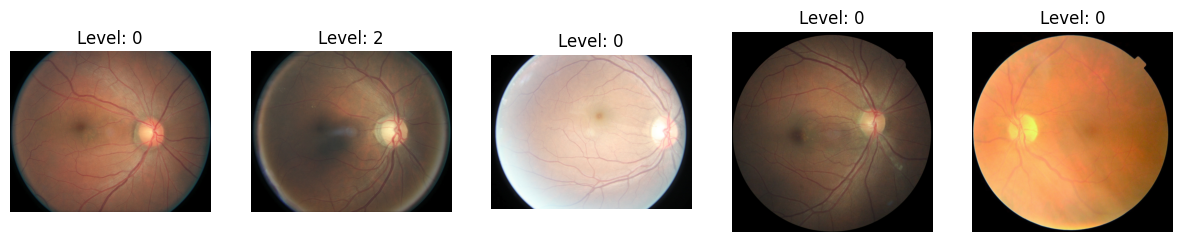

In [ ]:
# Function to show sample images
def show_sample_images(df, data_dir, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))

    for i, idx in enumerate(df.sample(num_samples).index):
        img_name = df.loc[idx, "image"] + ".jpeg"
        img_path = os.path.join(data_dir, img_name)

        # Read and display the image
        img = cv2.imread(img_path)

        # Check if the image was loaded successfully
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
            axes[i].set_title(f"Level: {df.loc[idx, 'level']}")
            axes[i].axis("off")
        else:
            print(f"Failed to load image: {img_path}")

    plt.show()

# Correct the data_dir path
data_dir = "resized_train_cropped/resized_train_cropped" # Updated path

# Display sample images
show_sample_images(df, data_dir)

**Clean the DataFrame**

In [ ]:
# Drop unnecessary columns
df = df[['image', 'level']]
print("Cleaned DataFrame:")
df.head()

Cleaned DataFrame:


,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


**Check If Image Files Exist**

In [ ]:
# Function to check missing images
missing_images = [img for img in df['image'] if not os.path.exists(os.path.join(data_dir, img + ".jpeg"))]

if missing_images:
    print(f"Warning: {len(missing_images)} images are missing!")
else:
    print("All images are present!")


All images are present!


**Data Preprocessing for Model Training**

In [ ]:
import tensorflow as tf
ImageDataGenerator = tf.keras.preprocessing.image.ImageDataGenerator
from sklearn.model_selection import train_test_split

# Define image size and batch size
IMG_SIZE = (224, 224)  # Resize images to 224x224 for model input
BATCH_SIZE = 32

# Add full image paths (fix warning)
df.loc[:, "image_path"] = df["image"].apply(lambda x: os.path.join(data_dir, x + ".jpeg"))

# Split into training (80%) and validation (20%) sets
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["level"], random_state=42)

print(f"Training Samples: {len(train_df)}, Validation Samples: {len(val_df)}")


Training Samples: 28086, Validation Samples: 7022


**Create Data Generators for Model Input**

In [ ]:
# Image Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only normalize validation set

# Create Data Loaders
train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col="image_path", y_col="level",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="raw", shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col="image_path", y_col="level",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="raw", shuffle=False
)


Found 28086 validated image filenames.
Found 7022 validated image filenames.


**Build a Deep Learning Model**

1. Import Required Libraries & Define the Model

In [ ]:
import tensorflow as tf

# Load EfficientNetB0 without the top classification layer
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='linear')  # Regression output for DR severity level
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])  # Mean Absolute Error (MAE) for evaluation

# Show model summary
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

**Train the Model**

In [ ]:
tf.debugging.set_log_device_placement(True)

1. Train the Model

In [ ]:
# Define number of epochs
EPOCHS = 10

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Epoch 1/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 528s 602ms/step - loss: 0.9498 - mae: 0.7728 - val_loss: 0.9410 - val_mae: 0.7598
Epoch 2/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 528s 601ms/step - loss: 0.9293 - mae: 0.7632 - val_loss: 0.9405 - val_mae: 0.7657
Epoch 3/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 505s 575ms/step - loss: 0.9382 - mae: 0.7697 - val_loss: 0.9403 - val_mae: 0.7711
Epoch 4/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 526s 599ms/step - loss: 0.9345 - mae: 0.7687 - val_loss: 0.9404 - val_mae: 0.7758
Epoch 5/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 520s 592ms/step - loss: 0.9598 - mae: 0.7800 - val_loss: 0.9403 - val_mae: 0.7737
Epoch 6/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 572s 603ms/step - loss: 0.9521 - mae: 0.7756 - val_loss: 0.9404 - val_mae: 0.7758
Epoch 7/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 515s 586ms/step - loss: 0.9544 - mae: 0.7820 - val_loss: 0.9403 - val_mae: 0.7724
Epoch 8/10
878/878 ━━━━━━━━━━━━━━━━━━━━ 519s 592ms/step - loss: 0.9679 - mae: 0.7841 - val_loss: 0.9403 - val_mae: 0.7734
Epoch 9/10
878/878 ━━━━━

**Monitor Training Progress**

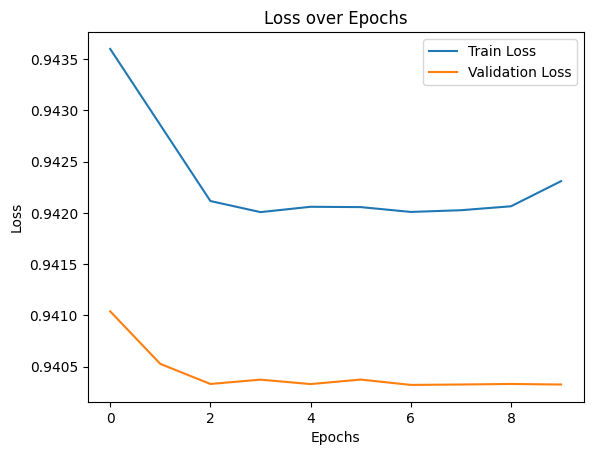

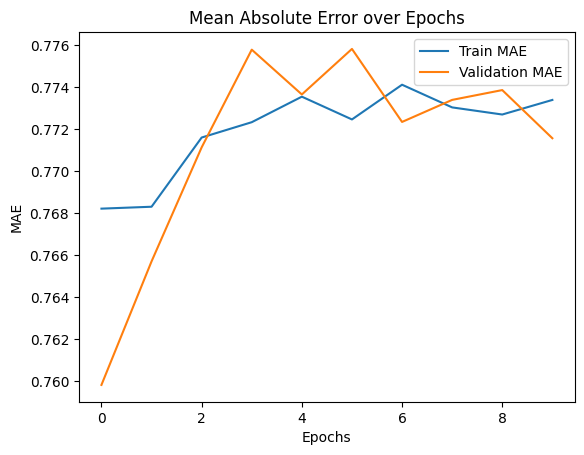

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Plot MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.title("Mean Absolute Error over Epochs")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.show()


**Save the Model**

In [ ]:
# Save the trained model
model.save("diabetic_retinopathy_model.h5")

print("Model saved successfully!")


Model saved successfully!


**Download the Model File**

In [ ]:
from google.colab import files

# Download the saved model
files.download("diabetic_retinopathy_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Step 11: Model Evaluation on Validation Data**

In [ ]:
# Evaluate on validation set
val_loss, val_mae = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

220/220 ━━━━━━━━━━━━━━━━━━━━ 51s 229ms/step - loss: 0.9420 - mae: 0.7757
Validation Loss: 0.9403
Validation MAE: 0.7716


**Step 12: Test the Model with New Images**

In [ ]:
from google.colab import files
import cv2
import numpy as np

# Upload a file
uploaded = files.upload()

# Get the uploaded file name
for filename in uploaded.keys():
    test_image_path = filename

print(f"Uploaded Image: {test_image_path}")

2. Preprocess and Predict

In [ ]:
# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Preprocess the uploaded image
img_array = preprocess_image(test_image_path)

# Make a prediction
prediction = model.predict(img_array)
predicted_label = round(float(prediction[0][0]))  # Round to closest severity level

print(f"Predicted Severity Level: {predicted_label}")
